In [80]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pickle

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# ============================================================
# LOAD DATA
# ============================================================
INDEX = "../processed_wlasl_top30_holistic/dataset_index.csv"
PICKLE = "../processed_wlasl_top30_holistic/asl_landmarks.pkl"

df = pd.read_csv(INDEX)
with open(PICKLE, "rb") as f:
    all_landmarks = pickle.load(f)

valid_ids = set(all_landmarks.keys())
before = len(df)
df = df[df["id"].astype(str).isin(valid_ids)].reset_index(drop=True)
after = len(df)

print(f"Filtered dataset: {before} to {after} rows remain")

labels = sorted(df["label"].unique())
class_to_idx = {c:i for i,c in enumerate(labels)}
idx_to_class = {i:c for c,i in class_to_idx.items()}  # Reverse mapping for predictions
num_classes = len(labels)

print("Classes:", num_classes)

# ============================================================
# DATASET → FORMAT FOR ST-GCN
# ST-GCN expects shape: (C, T, V)
#   C = 3 channels (x,y,z)
#   T = timesteps
#   V = joints (we will treat each feature triplet as a joint)
# ============================================================

class ASLGraphDataset(Dataset):
    def __init__(self, df, landmarks):
        self.df = df.reset_index(drop=True)
        self.landmarks = landmarks

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        vid = str(row["id"])

        lm = np.array(self.landmarks[vid])  # (T, D)
        T, D = lm.shape

        assert D % 3 == 0
        V = D // 3

        lm = lm.reshape(T, V, 3).transpose(2,0,1)  # → (3, T, V)

        x = torch.tensor(lm, dtype=torch.float32)
        y = class_to_idx[row["label"]]

        return x, torch.tensor(y)

# ============================================================
# SPLIT
# ============================================================
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df = df.iloc[: int(0.80*len(df))]
test_df  = df.iloc[int(0.80*len(df)) :]

train_ds = ASLGraphDataset(train_df, all_landmarks)
test_ds  = ASLGraphDataset(test_df, all_landmarks)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32)

# ============================================================
# Calculate actual number of joints from data
# ============================================================
sample_vid = str(df.iloc[0]["id"])
sample_lm = np.array(all_landmarks[sample_vid])  # (T, D)
T, D = sample_lm.shape
num_joints = D // 3  # Each joint has 3 coordinates (x, y, z)
print(f"Number of joints: {num_joints}")


Using device: cpu
Filtered dataset: 709 to 586 rows remain
Classes: 30
Number of joints: 125


In [81]:
# ============================================================
# Per-Joint Temporal Attention (PJTA) Module
# ============================================================
# This module applies temporal attention independently to each joint,
# allowing the model to learn which time steps are important for each joint.
# ============================================================

class PerJointTemporalAttention(nn.Module):
    """
    Per-Joint Temporal Attention: Applies self-attention over time
    for each joint independently, without spatial adjacency constraints.
    
    Input: (B, C, T, V) - batch, channels, time, joints
    Output: (B, C, V) - attended features per joint
    """
    def __init__(self, hidden_dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads
        
        assert hidden_dim % num_heads == 0, "hidden_dim must be divisible by num_heads"
        
        # Multi-head attention projections
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
        # Output projection
        self.out_proj = nn.Linear(hidden_dim, hidden_dim)
        
    def forward(self, x):
        """
        x: (B, C, T, V) - batch, channels, time, joints
        Returns: (B, C, V) - attended features per joint
        """
        # Get shape - torch.Size indexing returns Python ints directly
        # But to be safe, convert each to int explicitly
        B, C, T, V = x.shape
        # Convert to Python ints - torch.Size values are already ints, but ensure they are
        B = int(B) if isinstance(B, (int, torch.Size)) else int(B.item() if hasattr(B, 'item') else B)
        C = int(C) if isinstance(C, (int, torch.Size)) else int(C.item() if hasattr(C, 'item') else C)
        T = int(T) if isinstance(T, (int, torch.Size)) else int(T.item() if hasattr(T, 'item') else T)
        V = int(V) if isinstance(V, (int, torch.Size)) else int(V.item() if hasattr(V, 'item') else V)
        BV = B * V  # Pre-compute to ensure it's an int
        
        # Reshape to (B*V, T, C) - treat each joint separately
        # This allows each joint to have its own temporal attention pattern
        x_reshaped = x.permute(0, 3, 2, 1).contiguous()  # (B, V, T, C)
        x_reshaped = x_reshaped.reshape((BV, T, C))  # (B*V, T, C)
        
        # Store for residual connection
        residual = x_reshaped
        
        # Apply layer norm
        x_norm = self.layer_norm(x_reshaped)
        
        # Compute Q, K, V_attn (renamed to avoid conflict with V = num_joints)
        Q = self.query(x_norm)  # (B*V, T, C)
        K = self.key(x_norm)
        V_attn = self.value(x_norm)  # Renamed from V to avoid overwriting V (num_joints)
        
        # Reshape for multi-head attention
        # Ensure tensors are contiguous before reshaping and use tuple syntax
        Q = Q.contiguous().reshape((BV, T, self.num_heads, self.head_dim)).transpose(1, 2)  # (B*V, H, T, d)
        K = K.contiguous().reshape((BV, T, self.num_heads, self.head_dim)).transpose(1, 2)
        V_attn = V_attn.contiguous().reshape((BV, T, self.num_heads, self.head_dim)).transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=Q.dtype, device=Q.device))  # (B*V, H, T, T)
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Apply attention to values
        attn_output = torch.matmul(attn_weights, V_attn)  # (B*V, H, T, d)
        
        # Concatenate heads
        attn_output = attn_output.transpose(1, 2).contiguous()  # (B*V, T, H, d)
        attn_output = attn_output.contiguous().reshape((BV, T, C))  # (B*V, T, C)
        
        # Output projection
        attn_output = self.out_proj(attn_output)
        
        # Residual connection and reshape back
        output = residual + attn_output  # (B*V, T, C)
        
        # Temporal pooling: mean over time for each joint
        output = output.mean(dim=1)  # (B*V, C)
        
        # C should be self.hidden_dim (256) from TCN output
        # Use the known value instead of reading from tensor to avoid type issues
        C_out = self.hidden_dim  # This is already an int (256)
        
        # Reshape back to (B, V, C) then transpose to (B, C, V)
        # B and V are already Python ints from the beginning, C_out is also an int
        # Just ensure they're all ints one more time
        output = output.contiguous().reshape((B, V, C_out)).permute(0, 2, 1)  # (B, C, V)
        
        return output


In [82]:
# ============================================================
# Enhanced ST-GCN Model with Per-Joint Temporal Attention
# ============================================================

class STGCN_PJTA(nn.Module):
    """
    STGCN with Per-Joint Temporal Attention (PJTA).
    
    Architecture:
    1. Graph Convolutional Layers (spatial)
    2. Temporal Convolutional Network (temporal)
    3. Per-Joint Temporal Attention (joint-specific temporal attention)
    4. Classification Head  
    """
    def __init__(self, in_channels=3, num_class=30, num_joints=125, 
                 use_pjta=True, pjta_heads=4, dropout=0.1):
        super().__init__()
        
        self.use_pjta = use_pjta
        
        # Graph Convolutional Layers (spatial feature extraction)
        self.gcn1 = nn.Conv2d(in_channels, 64, kernel_size=(1,1))
        self.gcn2 = nn.Conv2d(64, 128, kernel_size=(1,1))
        
        # Temporal Convolutional Network
        self.tcn = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=(9,1), padding=(4,0)),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=(9,1), padding=(4,0)),
            nn.ReLU()
        )
        
        # Per-Joint Temporal Attention
        if use_pjta:
            self.pjta = PerJointTemporalAttention(
                hidden_dim=256, 
                num_heads=pjta_heads,
                dropout=dropout
            )
            # After PJTA, we have (B, 256, V), so input to FC is 256*num_joints
            fc_input_dim = 256 * num_joints
        else:
            # Without PJTA, use global temporal pooling like original STGCN
            fc_input_dim = 256 * num_joints
        
        # Classification head
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(fc_input_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_class)
        )

    def forward(self, x):
        """
        x: (B, 3, T, V) - batch, channels, time, joints
        Returns: (B, num_class) - class logits
        """
        # Graph Convolutional Layers
        x = self.gcn1(x)  # (B, 64, T, V)
        x = self.gcn2(x)  # (B, 128, T, V)
        
        # Temporal Convolutional Network
        x = self.tcn(x)   # (B, 256, T, V)
        
        if self.use_pjta:
            # Per-Joint Temporal Attention
            # This applies temporal attention independently to each joint
            x = self.pjta(x)  # (B, 256, V)
        else:
            # Original STGCN: global temporal pooling
            x = x.mean(dim=2)  # (B, 256, V)
        
        # Flatten for classification
        # Get shape and convert to Python ints
        x_shape = x.shape
        B = int(x_shape[0])
        C = int(x_shape[1])
        V = int(x_shape[2])
        
        # Flatten: (B, C, V) -> (B, C*V)
        x = x.reshape((B, C * V))  # (B, 256*V)
        
        # Classification
        logits = self.fc(x)  # (B, num_class)
        
        return logits

# ============================================================
# Initialize Model
# ============================================================
model = STGCN_PJTA(
    num_class=num_classes, 
    num_joints=num_joints,
    use_pjta=True,  # Enable Per-Joint Temporal Attention
    pjta_heads=4,   # Number of attention heads
    dropout=0.3
).to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel initialized with PJTA enabled")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)



Model initialized with PJTA enabled
Total parameters: 17,114,910
Trainable parameters: 17,114,910


In [83]:
# ============================================================
# TRAIN LOOP
# ============================================================
from tqdm import tqdm

best_acc = 0
best_epoch = 0
SAVE_PATH = "best_stgcn_pjta.pt"

num_epochs = 100

history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

for epoch in range(num_epochs):
    model.train()
    total, correct, train_loss = 0, 0, 0

    # Training phase
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, p = pred.max(1)
        total += y.size(0)
        correct += (p == y).sum().item()

    train_acc = correct / total * 100

    # Evaluation phase
    model.eval()
    total, correct, test_loss = 0, 0, 0

    with torch.no_grad():
        for x, y in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test ]", leave=False):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            test_loss += loss.item()
            _, p = pred.max(1)
            total += y.size(0)
            correct += (p == y).sum().item()

    test_acc = correct / total * 100
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)


    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        best_epoch = epoch + 1
        torch.save({
            "epoch": epoch + 1,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "test_acc": test_acc,
            "train_acc": train_acc,
            "class_to_idx": class_to_idx,
            "idx_to_class": idx_to_class,
            "num_classes": num_classes,
            "num_joints": num_joints
        }, SAVE_PATH)
        print(f"\nNew Best Model Saved! Epoch {epoch+1} — Test Acc: {test_acc:.2f}%\n")

    # Print progress
    if (epoch + 1) % 5 == 0 or test_acc > best_acc:
        print(f"Epoch {epoch+1:03d} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Best: {best_acc:.2f}% (Epoch {best_epoch})")

print(f"\nTraining completed!")
print(f"Best test accuracy: {best_acc:.2f}% at epoch {best_epoch}")


Epoch 1/100 [Train]: 100%|██████████| 15/15 [01:34<00:00,  6.33s/it]



New Best Model Saved! Epoch 1 — Test Acc: 8.47%



Epoch 2/100 [Train]: 100%|██████████| 15/15 [01:28<00:00,  5.93s/it]



New Best Model Saved! Epoch 2 — Test Acc: 9.32%



Epoch 3/100 [Train]: 100%|██████████| 15/15 [01:34<00:00,  6.33s/it]



New Best Model Saved! Epoch 3 — Test Acc: 20.34%



Epoch 4/100 [Train]: 100%|██████████| 15/15 [01:33<00:00,  6.24s/it]



New Best Model Saved! Epoch 4 — Test Acc: 28.81%



Epoch 5/100 [Train]: 100%|██████████| 15/15 [01:30<00:00,  6.05s/it]



New Best Model Saved! Epoch 5 — Test Acc: 31.36%

Epoch 005 | Train Acc: 30.34% | Test Acc: 31.36% | Best: 31.36% (Epoch 5)


Epoch 6/100 [Train]: 100%|██████████| 15/15 [01:33<00:00,  6.24s/it]



New Best Model Saved! Epoch 6 — Test Acc: 36.44%



Epoch 7/100 [Train]: 100%|██████████| 15/15 [01:34<00:00,  6.28s/it]



New Best Model Saved! Epoch 7 — Test Acc: 41.53%



Epoch 10/100 [Train]: 100%|██████████| 15/15 [01:35<00:00,  6.36s/it]


Epoch 010 | Train Acc: 41.88% | Test Acc: 40.68% | Best: 41.53% (Epoch 7)


Epoch 12/100 [Train]: 100%|██████████| 15/15 [01:32<00:00,  6.16s/it]



New Best Model Saved! Epoch 12 — Test Acc: 42.37%



Epoch 15/100 [Train]: 100%|██████████| 15/15 [01:33<00:00,  6.25s/it]


Epoch 015 | Train Acc: 45.73% | Test Acc: 34.75% | Best: 42.37% (Epoch 12)


Epoch 20/100 [Train]: 100%|██████████| 15/15 [01:30<00:00,  6.04s/it]



New Best Model Saved! Epoch 20 — Test Acc: 44.07%

Epoch 020 | Train Acc: 52.14% | Test Acc: 44.07% | Best: 44.07% (Epoch 20)


Epoch 23/100 [Train]: 100%|██████████| 15/15 [01:31<00:00,  6.08s/it]



New Best Model Saved! Epoch 23 — Test Acc: 45.76%



Epoch 25/100 [Train]: 100%|██████████| 15/15 [01:31<00:00,  6.12s/it]



New Best Model Saved! Epoch 25 — Test Acc: 46.61%

Epoch 025 | Train Acc: 51.50% | Test Acc: 46.61% | Best: 46.61% (Epoch 25)


Epoch 30/100 [Train]: 100%|██████████| 15/15 [01:38<00:00,  6.58s/it]


Epoch 030 | Train Acc: 55.13% | Test Acc: 42.37% | Best: 46.61% (Epoch 25)


Epoch 35/100 [Train]: 100%|██████████| 15/15 [01:34<00:00,  6.32s/it]


Epoch 035 | Train Acc: 58.55% | Test Acc: 43.22% | Best: 46.61% (Epoch 25)


Epoch 40/100 [Train]: 100%|██████████| 15/15 [01:27<00:00,  5.86s/it]



New Best Model Saved! Epoch 40 — Test Acc: 48.31%

Epoch 040 | Train Acc: 57.05% | Test Acc: 48.31% | Best: 48.31% (Epoch 40)


Epoch 45/100 [Train]: 100%|██████████| 15/15 [01:32<00:00,  6.16s/it]


Epoch 045 | Train Acc: 58.97% | Test Acc: 46.61% | Best: 48.31% (Epoch 40)


Epoch 50/100 [Train]: 100%|██████████| 15/15 [01:33<00:00,  6.23s/it]


Epoch 050 | Train Acc: 62.39% | Test Acc: 47.46% | Best: 48.31% (Epoch 40)


Epoch 54/100 [Train]: 100%|██████████| 15/15 [01:30<00:00,  6.02s/it]



New Best Model Saved! Epoch 54 — Test Acc: 51.69%



Epoch 55/100 [Train]: 100%|██████████| 15/15 [01:31<00:00,  6.08s/it]


Epoch 055 | Train Acc: 66.24% | Test Acc: 49.15% | Best: 51.69% (Epoch 54)


Epoch 56/100 [Train]: 100%|██████████| 15/15 [01:30<00:00,  6.05s/it]



New Best Model Saved! Epoch 56 — Test Acc: 55.93%



Epoch 60/100 [Train]: 100%|██████████| 15/15 [01:35<00:00,  6.36s/it]


Epoch 060 | Train Acc: 66.88% | Test Acc: 53.39% | Best: 55.93% (Epoch 56)


Epoch 65/100 [Train]: 100%|██████████| 15/15 [01:31<00:00,  6.09s/it]


Epoch 065 | Train Acc: 67.74% | Test Acc: 50.85% | Best: 55.93% (Epoch 56)


Epoch 70/100 [Train]: 100%|██████████| 15/15 [01:34<00:00,  6.31s/it]


Epoch 070 | Train Acc: 63.68% | Test Acc: 52.54% | Best: 55.93% (Epoch 56)


Epoch 74/100 [Train]: 100%|██████████| 15/15 [01:33<00:00,  6.25s/it]



New Best Model Saved! Epoch 74 — Test Acc: 57.63%



Epoch 75/100 [Train]: 100%|██████████| 15/15 [01:28<00:00,  5.93s/it]


Epoch 075 | Train Acc: 67.52% | Test Acc: 57.63% | Best: 57.63% (Epoch 74)


Epoch 76/100 [Train]: 100%|██████████| 15/15 [01:38<00:00,  6.53s/it]



New Best Model Saved! Epoch 76 — Test Acc: 59.32%



Epoch 80/100 [Train]: 100%|██████████| 15/15 [01:36<00:00,  6.44s/it]


Epoch 080 | Train Acc: 74.36% | Test Acc: 56.78% | Best: 59.32% (Epoch 76)


Epoch 81/100 [Train]: 100%|██████████| 15/15 [01:34<00:00,  6.31s/it]



New Best Model Saved! Epoch 81 — Test Acc: 61.02%



Epoch 85/100 [Train]: 100%|██████████| 15/15 [01:32<00:00,  6.19s/it]


Epoch 085 | Train Acc: 78.21% | Test Acc: 55.93% | Best: 61.02% (Epoch 81)


Epoch 90/100 [Train]: 100%|██████████| 15/15 [01:41<00:00,  6.77s/it]


Epoch 090 | Train Acc: 79.06% | Test Acc: 59.32% | Best: 61.02% (Epoch 81)


Epoch 95/100 [Train]: 100%|██████████| 15/15 [01:47<00:00,  7.15s/it]


Epoch 095 | Train Acc: 82.69% | Test Acc: 58.47% | Best: 61.02% (Epoch 81)


Epoch 96/100 [Train]: 100%|██████████| 15/15 [01:28<00:00,  5.88s/it]



New Best Model Saved! Epoch 96 — Test Acc: 62.71%



Epoch 98/100 [Train]: 100%|██████████| 15/15 [01:29<00:00,  5.94s/it]



New Best Model Saved! Epoch 98 — Test Acc: 63.56%



Epoch 100/100 [Train]: 100%|██████████| 15/15 [01:28<00:00,  5.93s/it]
                                                                    

Epoch 100 | Train Acc: 84.40% | Test Acc: 61.02% | Best: 63.56% (Epoch 98)

Training completed!
Best test accuracy: 63.56% at epoch 98


In [84]:
# ============================================================
# Load Best Model and Evaluate
# ============================================================

# Re-initialize model
model = STGCN_PJTA(
    num_class=num_classes, 
    num_joints=num_joints,
    use_pjta=True,
    pjta_heads=4,
    dropout=0.1
).to(device)

# Load checkpoint
checkpoint = torch.load(SAVE_PATH, map_location=device)
if isinstance(checkpoint, dict) and "model_state" in checkpoint:
    model.load_state_dict(checkpoint["model_state"])
    print(f"Loaded model from epoch {checkpoint.get('epoch', 'unknown')}")
    print(f"Test accuracy: {checkpoint.get('test_acc', 'unknown'):.2f}%")
    
    # Use checkpoint class mappings if available
    if "idx_to_class" in checkpoint:
        checkpoint_idx_to_class = checkpoint["idx_to_class"]
        if len(checkpoint_idx_to_class) > 0 and isinstance(next(iter(checkpoint_idx_to_class.keys())), torch.Tensor):
            checkpoint_idx_to_class = {k.item() if isinstance(k, torch.Tensor) else k: v 
                                     for k, v in checkpoint_idx_to_class.items()}
        idx_to_class = checkpoint_idx_to_class
        print(f"Using class mappings from checkpoint ({len(idx_to_class)} classes)")
else:
    model.load_state_dict(checkpoint)
    print("Loaded model (old format)")

model.eval()

# Final evaluation
def evaluate(loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            _, predicted = pred.max(1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    return correct / total

test_acc = evaluate(test_loader) * 100
train_acc = evaluate(train_loader) * 100

print(f"\nFinal Results:")
print(f"Train Accuracy: {train_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")


Loaded model from epoch 98
Test accuracy: 63.56%
Using class mappings from checkpoint (30 classes)

Final Results:
Train Accuracy: 93.16%
Test Accuracy: 63.56%


In [85]:
# ============================================================
# Prediction Functions
# ============================================================
import torch.nn.functional as F

def predict_video(model, landmarks, idx_to_class, debug=False):
    """
    Predict ASL sign from landmarks using STGCN-PJTA model.
    
    Args:
        model: Trained STGCN_PJTA model
        landmarks: (T, D) numpy array or tensor where T is number of frames (typically 60) 
                   and D is feature dimension (375 for holistic = 125 joints * 3)
        idx_to_class: dictionary mapping class index to class name (from training)
        debug: If True, print debug information
    
    Returns:
        pred_word: Predicted class name
        confidence: Prediction confidence (0-1)
    """
    model.eval()
    
    # Convert to numpy if tensor
    if isinstance(landmarks, torch.Tensor):
        landmarks = landmarks.cpu().numpy()
    
    # Ensure float32
    landmarks = np.array(landmarks, dtype=np.float32)
    
    # STGCN expects (C, T, V) format where C=3, T=timesteps, V=joints
    T, D = landmarks.shape
    
    if debug:
        print(f"Input shape: (T={T}, D={D})")
    
    # Validate dimensions
    assert D % 3 == 0, f"Feature dimension {D} must be divisible by 3"
    V = D // 3  # Number of joints
    
    # Reshape to (T, V, 3) then transpose to (3, T, V) - same as ASLGraphDataset
    lm = landmarks.reshape(T, V, 3).transpose(2, 0, 1)  # → (3, T, V)
    
    if debug:
        print(f"After reshape/transpose: {lm.shape}, expected (3, T, V)")
    
    # Convert to tensor and add batch dimension: (1, 3, T, V)
    x = torch.tensor(lm, dtype=torch.float32).unsqueeze(0)
    x = x.to(next(model.parameters()).device)
    
    if debug:
        print(f"Model input shape: {x.shape}, expected (1, 3, T, V)")
    
    with torch.no_grad():
        logits = model(x)  # (1, num_classes)
        
        if debug:
            print(f"Logits shape: {logits.shape}")
            top5 = torch.topk(logits, 5, dim=1)
            print(f"Top 5 predictions:")
            for i, (val, idx) in enumerate(zip(top5.values[0], top5.indices[0])):
                class_name = idx_to_class.get(idx.item(), f"Unknown_{idx.item()}")
                print(f"  {i+1}. {class_name}: {F.softmax(logits, dim=1)[0][idx].item():.4f}")
        
        probs = F.softmax(logits, dim=1)
        conf, pred_idx = torch.max(probs, dim=1)
        
        pred_idx_val = pred_idx.item()
        
        if debug:
            print(f"Predicted index: {pred_idx_val}, Confidence: {conf.item():.4f}")
        
        # Bounds checking
        if pred_idx_val not in idx_to_class:
            max_idx = max(idx_to_class.keys()) if idx_to_class else 0
            if pred_idx_val > max_idx:
                pred_idx_val = max_idx
            elif pred_idx_val < 0:
                pred_idx_val = 0
            if pred_idx_val not in idx_to_class:
                pred_idx_val = min(idx_to_class.keys()) if idx_to_class else 0

    pred_word = idx_to_class.get(pred_idx_val, f"Unknown_{pred_idx_val}")
    confidence = conf.item()

    return pred_word, confidence

def print_predictions(model, df, landmarks_dict, idx_to_class, num_samples=10):
    """
    Randomly prints `num_samples` predictions from df.
    """
    sample_df = df.sample(num_samples).reset_index(drop=True)

    for i in range(len(sample_df)):
        video_id = str(sample_df.iloc[i]["id"])
        path = sample_df.iloc[i]["path"]
        true_label = sample_df.iloc[i]["label"]
        
        if video_id not in landmarks_dict:
            print(f"{i+1}. {path}")
            print(f"   True:      {true_label}")
            print(f"   Predicted: ERROR - Video ID {video_id} not found in landmarks")
            print()
            continue
            
        lm = landmarks_dict[video_id]
        # Use debug=True for first sample
        pred, conf = predict_video(model, lm, idx_to_class, debug=(i == 0))

        print(f"{i+1}. {path}")
        print(f"   True:      {true_label}")
        print(f"   Predicted: {pred}  (conf: {conf:.2f})")
        print()

# Test predictions
print("Sample predictions on test set:")
print_predictions(model, test_df, all_landmarks, idx_to_class, num_samples=10)


Sample predictions on test set:
Input shape: (T=60, D=375)
After reshape/transpose: (3, 60, 125), expected (3, T, V)
Model input shape: torch.Size([1, 3, 60, 125]), expected (1, 3, T, V)
Logits shape: torch.Size([1, 30])
Top 5 predictions:
  1. who: 0.4044
  2. mother: 0.2324
  3. drink: 0.0811
  4. orange: 0.0753
  5. finish: 0.0266
Predicted index: 27, Confidence: 0.4044
1. wlasl-complete/videos/69534.mp4
   True:      who
   Predicted: who  (conf: 0.40)

2. wlasl-complete/videos/13631.mp4
   True:      cousin
   Predicted: drink  (conf: 0.36)

3. wlasl-complete/videos/69396.mp4
   True:      many
   Predicted: now  (conf: 0.13)

4. wlasl-complete/videos/14889.mp4
   True:      deaf
   Predicted: deaf  (conf: 0.37)

5. wlasl-complete/videos/65415.mp4
   True:      cousin
   Predicted: cousin  (conf: 0.72)

6. wlasl-complete/videos/57630.mp4
   True:      thanksgiving
   Predicted: thin  (conf: 0.17)

7. wlasl-complete/videos/57942.mp4
   True:      thin
   Predicted: thin  (conf: 0.2

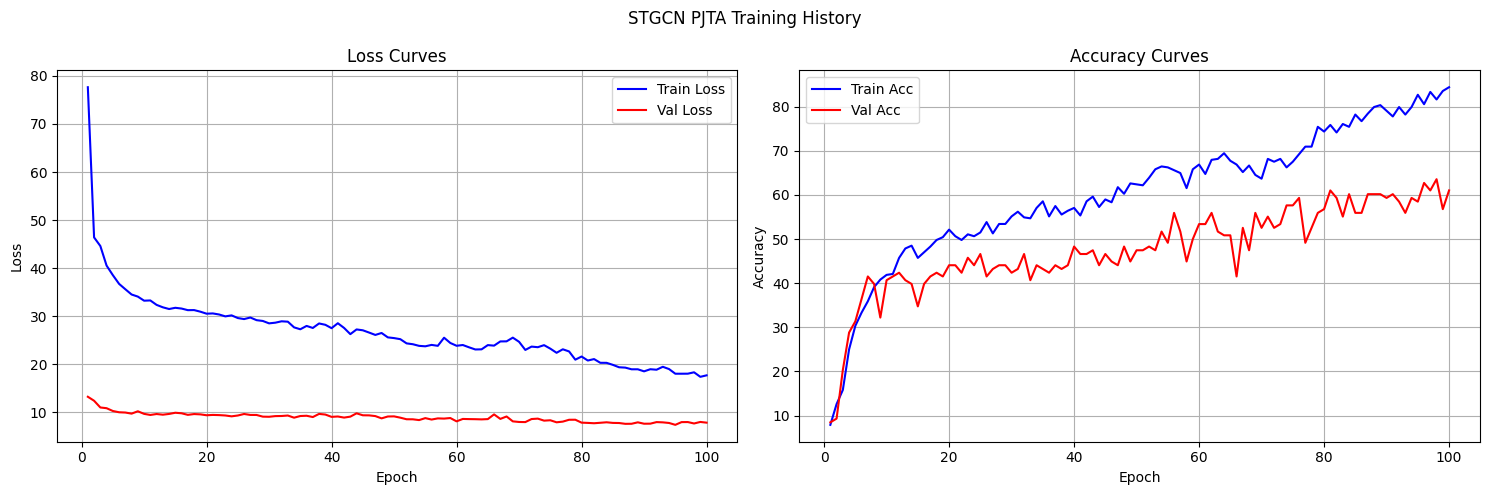

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(history['train_loss']) + 1)

# Plot loss
ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs, history['test_loss'], 'r-', label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss Curves')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
ax2.plot(epochs, history['test_acc'], 'r-', label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy Curves')
ax2.legend()
ax2.grid(True)

plt.suptitle("STGCN PJTA Training History")
plt.tight_layout()
plt.show()
